# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

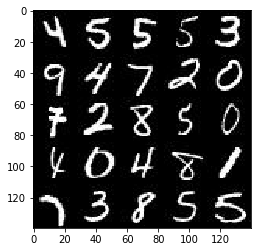

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

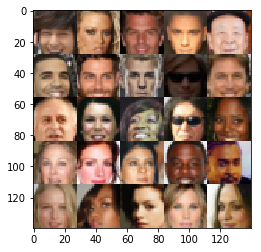

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/josh/anaconda3/envs/dl2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    input_real = tf.placeholder(tf.float32, [None, image_height, image_width, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [239]:
from tensorflow.python.layers import utils


d_filters = [64, 128, 256]
d_kernels = [5, 5, 5]
d_strides = [2, 2, 2]
d_padding = ['same', 'same', 'same']
w = 28
print("{}x{}x{}".format(w,w,'channels'))
for f, k, s, p in zip(d_filters, d_kernels, d_strides, d_padding):
    print("  conv2d(x, {}, {}, strides={}, padding={})".format(f, k, s, p))
    w = utils.conv_output_length(w, k, p, s)
    print("{}x{}x{}".format(w,w,f))

28x28xchannels
  conv2d(x, 64, 5, strides=2, padding=same)
14x14x64
  conv2d(x, 128, 5, strides=2, padding=same)
7x7x128
  conv2d(x, 256, 5, strides=2, padding=same)
4x4x256


In [240]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):        
        x = tf.layers.conv2d(images, 
                             d_filters[0], 
                             d_kernels[0], 
                             strides=d_strides[0], 
                             padding=d_padding[0], 
                             activation=None)
        x = tf.maximum(0.2*x, x)
        
        # build convolutional layers using helper above
        for f, k, s, p in zip(d_filters[1:], d_kernels[1:], d_strides[1:], d_padding[1:]):
            x = tf.layers.conv2d(x, f, k, strides=s, padding=p, activation=None)
            x = tf.layers.batch_normalization(x, training=True)
            x = tf.maximum(0.2*x, x)
        
        # Flatten and generate logits and softmax
        x = tf.layers.flatten(x)
        logits = tf.layers.dense(x, 1, activation=None)
        out = tf.nn.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [241]:
first_layer_size = 3
dense_size = 512

g_filters = [256, 128, 64, 'channels']
g_kernels = [5, 5, 5, 3]
g_strides = [1, 2, 2, 1]
g_padding = ['valid', 'same', 'same', 'same']

# g_filters = [256, 128, 'channels']
# g_kernels = [5, 5, 5]
# g_strides = [2, 2, 2]
# g_padding = ['valid', 'same', 'same']

print('z_dim')
print("  Dense layer with {} neurons and reshape to:".format(first_layer_size*first_layer_size*dense_size))
print("{}x{}x{}".format(first_layer_size,first_layer_size,dense_size))

w = first_layer_size
for f, k, s, p in zip(g_filters, g_kernels, g_strides, g_padding):
    print("  conv2d_transpose(x, {}, {}, strides={}, padding={})".format(f, k, s, p))
    w = utils.deconv_output_length(w, k, p, s)
    print("{}x{}x{}".format(w,w,f))

z_dim
  Dense layer with 4608 neurons and reshape to:
3x3x512
  conv2d_transpose(x, 256, 5, strides=1, padding=valid)
7x7x256
  conv2d_transpose(x, 128, 5, strides=2, padding=same)
14x14x128
  conv2d_transpose(x, 64, 5, strides=2, padding=same)
28x28x64
  conv2d_transpose(x, channels, 3, strides=1, padding=same)
28x28xchannels


In [242]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope("generator", reuse=not is_train):
        # vector -> 3x3
        x = tf.layers.dense(z, first_layer_size*first_layer_size*dense_size)
        x = tf.reshape(x, (-1, first_layer_size, first_layer_size, dense_size))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(0.2*x, x)
#         x = tf.nn.relu(x)

        # Build layers using helper above
        for f, k, s, p in zip(g_filters[:-1], g_kernels[:-1], g_strides[:-1], g_padding[:-1]):
            x = tf.layers.conv2d_transpose(x, f, k, strides=s, padding=p, activation=None)
            x = tf.layers.batch_normalization(x, training=is_train)
            x = tf.maximum(0.2*x, x)
#             x = tf.nn.relu(x)

        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 
                                            g_kernels[-1], 
                                            strides=g_strides[-1], 
                                            padding=g_padding[-1], 
                                            activation=None)
        out = tf.nn.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [243]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    smooth = 0.1
    
    input_fake = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(input_fake, reuse=True)

    real_labels = tf.ones_like(d_model_real)
    fake_labels = tf.zeros_like(d_model_fake)
    
    # Discriminator loss on real images
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                    labels=(1-smooth) * real_labels))
    
    # Discriminator loss on fake images
    d_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=fake_labels))
    
    # Generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=real_labels))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [244]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    d_vars = tf.trainable_variables(scope='discriminator')
    g_vars = tf.trainable_variables(scope='generator')
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [245]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [246]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 10
    plot_every = 100
    
    # Build Model
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        batch_i = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Rescale data range from +/-0.5 to +/-1.0
                batch_images *= 2
                
                z_batch = np.random.uniform(-1.0, 1.0, [batch_size, z_dim])
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: z_batch, 
                                                     lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: z_batch, 
                                                     lr: learning_rate})
                
                # Print training loss
                if batch_i%print_every == 0:
                    training_d_loss = d_loss.eval({input_real: batch_images, input_z: z_batch})
                    training_g_loss = g_loss.eval({input_real: batch_images, input_z: z_batch})
                    print("Epoch {}/{:<8d} d_loss {:<8.4f} g_loss {:<8.4f}".format(epoch_i+1, 
                                                                                   epoch_count,
                                                                                   training_d_loss, 
                                                                                   training_g_loss))
                
                # Show generator output
                if batch_i%plot_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[-1], data_image_mode)
                batch_i += 1
        
        # Final generator result
        show_generator_output(sess, batch_size, input_z, data_shape[-1], data_image_mode)

In [247]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print("MNIST Data shape:", mnist_dataset.shape)
batch_gen = mnist_dataset.get_batches(10)
test_batch = next(batch_gen)
print("data range: {:.1f} to {:.1f}".format(np.min(test_batch), np.max(test_batch)))
print("tanh range: {:.1f} to {:.1f}".format(np.tanh(-10), np.tanh(10)))

MNIST Data shape: (60000, 28, 28, 1)
data range: -0.5 to 0.5
tanh range: -1.0 to 1.0


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2        d_loss 15.3255  g_loss 0.0000  


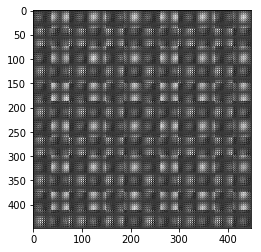

Epoch 1/2        d_loss 0.4489   g_loss 14.6092 
Epoch 1/2        d_loss 0.3838   g_loss 3.5200  
Epoch 1/2        d_loss 3.3438   g_loss 0.0725  
Epoch 1/2        d_loss 0.5887   g_loss 2.1897  
Epoch 1/2        d_loss 0.7008   g_loss 7.8036  
Epoch 1/2        d_loss 0.6016   g_loss 2.9105  
Epoch 1/2        d_loss 0.5756   g_loss 2.3824  
Epoch 1/2        d_loss 0.4101   g_loss 3.2701  
Epoch 1/2        d_loss 0.5647   g_loss 2.2341  
Epoch 1/2        d_loss 0.4686   g_loss 2.7635  


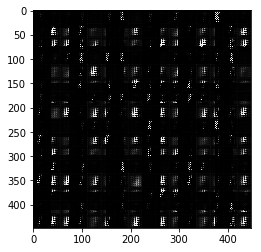

Epoch 1/2        d_loss 0.7698   g_loss 6.5595  
Epoch 1/2        d_loss 0.7203   g_loss 1.5550  
Epoch 1/2        d_loss 0.6562   g_loss 2.0934  
Epoch 1/2        d_loss 0.5594   g_loss 2.6466  
Epoch 1/2        d_loss 0.9839   g_loss 1.8354  
Epoch 1/2        d_loss 1.2393   g_loss 3.7371  
Epoch 1/2        d_loss 0.7891   g_loss 1.4916  
Epoch 1/2        d_loss 1.4562   g_loss 3.1722  
Epoch 1/2        d_loss 0.7198   g_loss 1.8646  
Epoch 1/2        d_loss 1.5417   g_loss 0.4969  


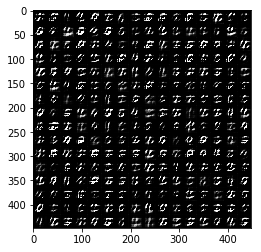

Epoch 1/2        d_loss 1.1180   g_loss 1.2538  
Epoch 1/2        d_loss 0.8912   g_loss 2.4687  
Epoch 1/2        d_loss 1.0724   g_loss 1.1912  
Epoch 2/2        d_loss 0.9995   g_loss 0.9990  
Epoch 2/2        d_loss 0.9601   g_loss 1.5116  
Epoch 2/2        d_loss 0.8295   g_loss 2.2548  
Epoch 2/2        d_loss 0.8850   g_loss 1.4714  
Epoch 2/2        d_loss 0.9869   g_loss 1.7061  
Epoch 2/2        d_loss 1.1154   g_loss 2.1292  
Epoch 2/2        d_loss 1.1230   g_loss 1.8638  


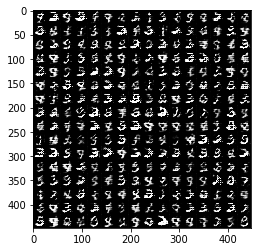

Epoch 2/2        d_loss 1.1078   g_loss 0.9869  
Epoch 2/2        d_loss 1.1698   g_loss 1.3140  
Epoch 2/2        d_loss 1.0338   g_loss 1.8574  
Epoch 2/2        d_loss 0.9739   g_loss 1.2784  
Epoch 2/2        d_loss 1.1586   g_loss 0.8377  
Epoch 2/2        d_loss 1.0933   g_loss 1.7181  
Epoch 2/2        d_loss 1.1288   g_loss 1.8014  
Epoch 2/2        d_loss 1.1071   g_loss 1.2191  
Epoch 2/2        d_loss 1.2651   g_loss 0.7386  
Epoch 2/2        d_loss 1.0363   g_loss 1.3241  


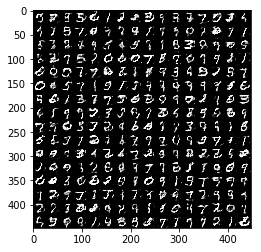

Epoch 2/2        d_loss 1.2534   g_loss 0.6828  
Epoch 2/2        d_loss 1.1451   g_loss 0.9336  
Epoch 2/2        d_loss 1.3968   g_loss 0.5341  
Epoch 2/2        d_loss 1.6046   g_loss 0.4297  
Epoch 2/2        d_loss 1.1081   g_loss 1.2423  
Epoch 2/2        d_loss 1.0956   g_loss 1.4300  


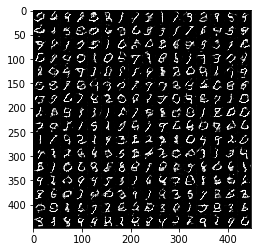

In [250]:
batch_size = 256
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [205]:
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
print("CelebA Data shape:", celeba_dataset.shape)
batch_gen = celeba_dataset.get_batches(10)
test_batch = next(batch_gen)
print("data range: {:.1f} to {:.1f}".format(np.min(test_batch), np.max(test_batch)))
print("tanh range: {:.1f} to {:.1f}".format(np.tanh(-10), np.tanh(10)))

CelebA Data shape: (202599, 28, 28, 3)
data range: -0.5 to 0.5
tanh range: -1.0 to 1.0


Epoch 1/1        d_loss 13.5561  g_loss 0.0000  


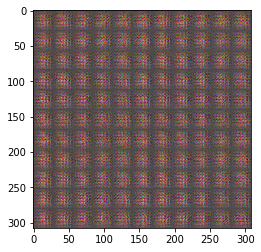

Epoch 1/1        d_loss 0.7390   g_loss 8.4426  
Epoch 1/1        d_loss 0.4665   g_loss 11.5231 
Epoch 1/1        d_loss 0.5366   g_loss 15.7268 
Epoch 1/1        d_loss 0.5837   g_loss 6.9934  
Epoch 1/1        d_loss 0.6054   g_loss 13.0062 
Epoch 1/1        d_loss 0.4939   g_loss 2.9087  
Epoch 1/1        d_loss 0.6313   g_loss 2.0064  
Epoch 1/1        d_loss 2.9346   g_loss 0.0951  
Epoch 1/1        d_loss 0.5866   g_loss 2.9615  
Epoch 1/1        d_loss 0.6733   g_loss 2.2610  


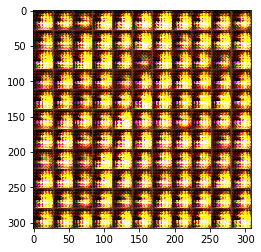

Epoch 1/1        d_loss 0.8437   g_loss 4.7088  
Epoch 1/1        d_loss 0.5298   g_loss 3.1097  
Epoch 1/1        d_loss 0.7214   g_loss 4.2993  
Epoch 1/1        d_loss 0.4793   g_loss 4.0252  
Epoch 1/1        d_loss 1.2089   g_loss 0.6727  
Epoch 1/1        d_loss 0.6777   g_loss 1.9098  
Epoch 1/1        d_loss 1.9491   g_loss 7.8791  
Epoch 1/1        d_loss 0.8194   g_loss 1.5209  
Epoch 1/1        d_loss 2.9665   g_loss 5.9797  
Epoch 1/1        d_loss 0.7636   g_loss 2.3993  


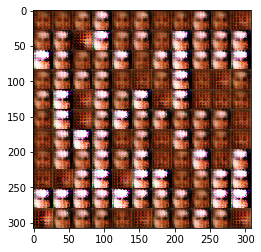

Epoch 1/1        d_loss 0.8107   g_loss 1.4338  
Epoch 1/1        d_loss 1.4133   g_loss 1.1881  
Epoch 1/1        d_loss 0.7515   g_loss 1.7441  
Epoch 1/1        d_loss 0.8048   g_loss 1.3842  
Epoch 1/1        d_loss 1.1260   g_loss 1.4365  
Epoch 1/1        d_loss 0.5987   g_loss 2.4951  
Epoch 1/1        d_loss 1.3160   g_loss 0.5913  
Epoch 1/1        d_loss 0.7473   g_loss 2.1868  
Epoch 1/1        d_loss 1.1925   g_loss 1.5679  
Epoch 1/1        d_loss 0.9280   g_loss 1.3101  


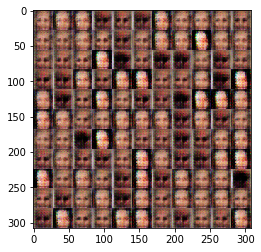

Epoch 1/1        d_loss 1.0017   g_loss 2.1643  
Epoch 1/1        d_loss 0.9718   g_loss 1.7231  
Epoch 1/1        d_loss 0.7582   g_loss 1.6147  
Epoch 1/1        d_loss 0.8695   g_loss 1.9586  
Epoch 1/1        d_loss 1.4514   g_loss 0.7044  
Epoch 1/1        d_loss 2.2758   g_loss 0.3511  
Epoch 1/1        d_loss 1.1685   g_loss 0.7816  
Epoch 1/1        d_loss 0.9095   g_loss 2.3988  
Epoch 1/1        d_loss 1.1160   g_loss 1.7845  
Epoch 1/1        d_loss 0.6093   g_loss 2.3218  


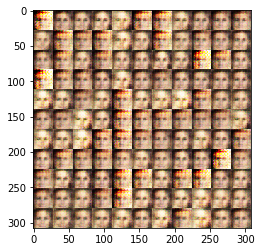

Epoch 1/1        d_loss 0.9196   g_loss 1.6475  
Epoch 1/1        d_loss 0.6623   g_loss 1.9089  
Epoch 1/1        d_loss 0.7123   g_loss 1.6543  
Epoch 1/1        d_loss 2.2885   g_loss 5.9012  
Epoch 1/1        d_loss 1.9090   g_loss 2.8106  
Epoch 1/1        d_loss 1.2700   g_loss 1.8135  
Epoch 1/1        d_loss 0.8401   g_loss 1.3826  
Epoch 1/1        d_loss 3.0115   g_loss 5.2553  
Epoch 1/1        d_loss 1.0859   g_loss 0.9119  
Epoch 1/1        d_loss 0.9346   g_loss 2.3795  


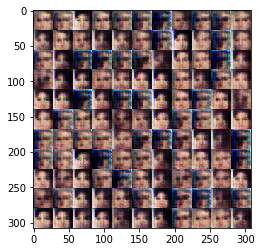

Epoch 1/1        d_loss 1.2635   g_loss 0.6483  
Epoch 1/1        d_loss 0.9360   g_loss 1.6070  
Epoch 1/1        d_loss 0.6780   g_loss 1.7665  
Epoch 1/1        d_loss 1.0970   g_loss 1.4209  
Epoch 1/1        d_loss 0.8866   g_loss 1.0703  
Epoch 1/1        d_loss 1.2431   g_loss 3.0759  
Epoch 1/1        d_loss 1.0314   g_loss 1.0496  
Epoch 1/1        d_loss 0.8568   g_loss 1.4851  
Epoch 1/1        d_loss 0.8214   g_loss 1.6447  
Epoch 1/1        d_loss 1.4585   g_loss 1.4662  


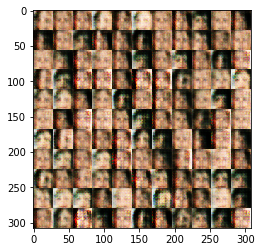

Epoch 1/1        d_loss 1.1534   g_loss 1.5143  
Epoch 1/1        d_loss 0.8292   g_loss 1.5051  
Epoch 1/1        d_loss 0.9315   g_loss 1.0603  
Epoch 1/1        d_loss 1.1248   g_loss 1.0063  
Epoch 1/1        d_loss 1.0208   g_loss 1.3615  
Epoch 1/1        d_loss 1.0083   g_loss 1.1692  
Epoch 1/1        d_loss 1.0074   g_loss 1.1275  
Epoch 1/1        d_loss 0.9134   g_loss 2.7825  
Epoch 1/1        d_loss 1.5321   g_loss 2.6876  
Epoch 1/1        d_loss 0.8310   g_loss 1.4064  


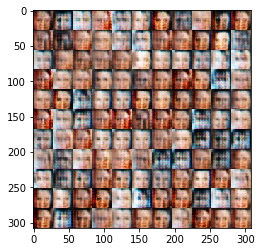

Epoch 1/1        d_loss 1.1345   g_loss 1.1813  
Epoch 1/1        d_loss 1.1093   g_loss 1.8346  
Epoch 1/1        d_loss 0.9702   g_loss 1.2410  
Epoch 1/1        d_loss 1.3562   g_loss 2.9165  
Epoch 1/1        d_loss 1.1963   g_loss 2.8040  
Epoch 1/1        d_loss 1.1110   g_loss 1.0183  
Epoch 1/1        d_loss 1.2753   g_loss 1.1812  
Epoch 1/1        d_loss 0.9207   g_loss 1.7599  
Epoch 1/1        d_loss 1.2089   g_loss 1.0021  
Epoch 1/1        d_loss 1.2463   g_loss 0.7556  


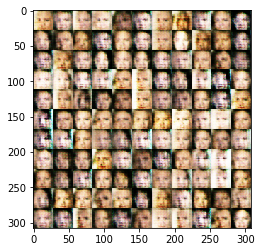

Epoch 1/1        d_loss 0.9869   g_loss 1.4043  
Epoch 1/1        d_loss 0.8081   g_loss 1.1316  
Epoch 1/1        d_loss 1.0583   g_loss 1.1664  
Epoch 1/1        d_loss 0.7595   g_loss 3.1602  
Epoch 1/1        d_loss 0.9419   g_loss 0.9375  
Epoch 1/1        d_loss 1.0114   g_loss 1.3849  
Epoch 1/1        d_loss 1.3302   g_loss 0.6294  
Epoch 1/1        d_loss 0.9676   g_loss 1.7782  
Epoch 1/1        d_loss 1.3309   g_loss 1.0353  
Epoch 1/1        d_loss 1.2001   g_loss 1.3396  


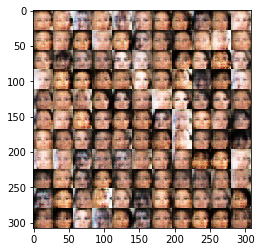

Epoch 1/1        d_loss 0.9706   g_loss 1.6943  
Epoch 1/1        d_loss 1.1722   g_loss 0.8168  
Epoch 1/1        d_loss 0.9632   g_loss 1.0999  
Epoch 1/1        d_loss 1.1382   g_loss 0.8547  
Epoch 1/1        d_loss 1.3429   g_loss 3.0887  
Epoch 1/1        d_loss 0.9848   g_loss 1.3903  
Epoch 1/1        d_loss 1.5144   g_loss 1.8223  
Epoch 1/1        d_loss 0.9775   g_loss 1.1280  
Epoch 1/1        d_loss 1.0230   g_loss 1.2900  
Epoch 1/1        d_loss 0.8617   g_loss 1.5959  


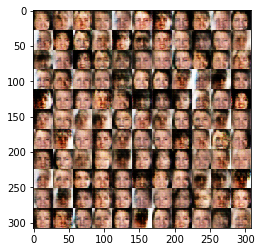

Epoch 1/1        d_loss 0.8881   g_loss 2.0303  
Epoch 1/1        d_loss 1.1665   g_loss 1.2846  
Epoch 1/1        d_loss 0.9329   g_loss 1.1769  
Epoch 1/1        d_loss 1.3516   g_loss 1.8500  
Epoch 1/1        d_loss 1.0033   g_loss 1.2097  
Epoch 1/1        d_loss 1.1890   g_loss 0.9942  
Epoch 1/1        d_loss 1.5170   g_loss 0.4790  
Epoch 1/1        d_loss 0.7389   g_loss 1.7255  
Epoch 1/1        d_loss 1.0488   g_loss 1.1778  
Epoch 1/1        d_loss 0.8258   g_loss 1.2820  


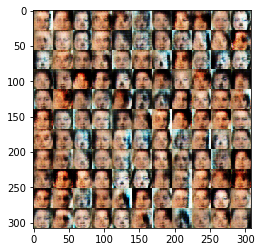

Epoch 1/1        d_loss 1.5634   g_loss 3.6791  
Epoch 1/1        d_loss 0.9283   g_loss 1.9520  
Epoch 1/1        d_loss 0.9899   g_loss 1.2910  
Epoch 1/1        d_loss 1.0520   g_loss 1.3271  
Epoch 1/1        d_loss 0.8927   g_loss 1.9030  
Epoch 1/1        d_loss 1.0775   g_loss 1.0772  
Epoch 1/1        d_loss 1.0345   g_loss 1.2470  
Epoch 1/1        d_loss 1.0658   g_loss 0.8330  
Epoch 1/1        d_loss 1.0047   g_loss 1.9624  
Epoch 1/1        d_loss 1.3859   g_loss 1.8267  


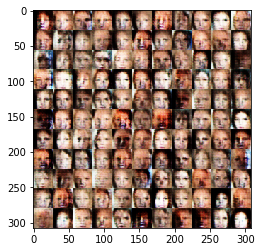

Epoch 1/1        d_loss 0.9508   g_loss 1.7789  
Epoch 1/1        d_loss 1.4107   g_loss 0.6900  
Epoch 1/1        d_loss 1.0285   g_loss 1.8989  
Epoch 1/1        d_loss 1.3944   g_loss 2.4339  
Epoch 1/1        d_loss 1.2573   g_loss 0.7683  
Epoch 1/1        d_loss 1.0470   g_loss 1.4658  
Epoch 1/1        d_loss 1.3631   g_loss 0.6224  
Epoch 1/1        d_loss 1.3165   g_loss 0.6466  
Epoch 1/1        d_loss 1.4401   g_loss 0.5308  
Epoch 1/1        d_loss 0.8840   g_loss 1.4671  


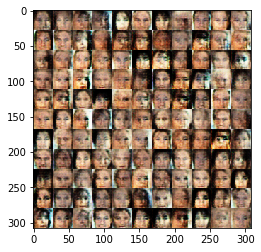

Epoch 1/1        d_loss 1.1598   g_loss 0.8958  
Epoch 1/1        d_loss 1.0004   g_loss 1.5628  
Epoch 1/1        d_loss 1.2192   g_loss 0.7270  
Epoch 1/1        d_loss 1.2665   g_loss 0.8309  
Epoch 1/1        d_loss 1.0683   g_loss 1.1064  
Epoch 1/1        d_loss 1.1446   g_loss 0.8548  
Epoch 1/1        d_loss 1.1087   g_loss 1.0522  
Epoch 1/1        d_loss 1.5912   g_loss 0.4410  
Epoch 1/1        d_loss 1.2476   g_loss 0.6835  
Epoch 1/1        d_loss 1.0507   g_loss 1.6106  


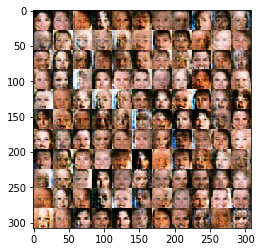

Epoch 1/1        d_loss 1.1594   g_loss 1.6497  
Epoch 1/1        d_loss 1.1547   g_loss 1.3029  
Epoch 1/1        d_loss 1.3972   g_loss 0.6007  
Epoch 1/1        d_loss 1.1658   g_loss 1.3285  
Epoch 1/1        d_loss 1.1858   g_loss 0.7837  
Epoch 1/1        d_loss 1.0703   g_loss 1.0732  
Epoch 1/1        d_loss 1.0149   g_loss 1.1040  
Epoch 1/1        d_loss 1.1990   g_loss 0.8935  
Epoch 1/1        d_loss 1.5246   g_loss 0.8852  
Epoch 1/1        d_loss 1.0127   g_loss 1.2505  


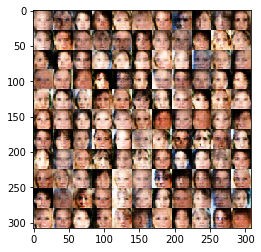

Epoch 1/1        d_loss 1.1767   g_loss 1.3091  
Epoch 1/1        d_loss 1.1939   g_loss 0.8375  
Epoch 1/1        d_loss 1.1253   g_loss 0.9592  
Epoch 1/1        d_loss 1.1184   g_loss 1.1626  
Epoch 1/1        d_loss 1.2753   g_loss 2.2852  
Epoch 1/1        d_loss 1.5572   g_loss 0.4704  
Epoch 1/1        d_loss 1.1436   g_loss 1.6439  
Epoch 1/1        d_loss 1.1520   g_loss 1.2363  


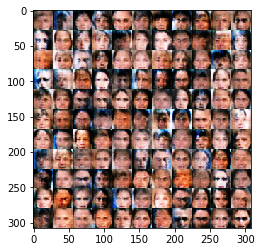

In [252]:
batch_size = 128
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.